In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

dataset_path = "/content/drive/My Drive/sem 7/cifar10"
os.makedirs(dataset_path, exist_ok=True)

print("Dataset akan disimpan di:", dataset_path)


Dataset akan disimpan di: /content/drive/My Drive/sem 7/cifar10


In [3]:
!pip install timm


In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transformasi dataset (resize 224)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

# Download CIFAR-10 ke Google Drive
trainset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=False, download=True, transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

print("Trainloader dan Testloader siap!")


Trainloader dan Testloader siap!


In [5]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model DeiT-small & Swin-tiny
model_deit = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=10)
model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=10)

model_deit = model_deit.to(device)
model_swin = model_swin.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_deit = optim.AdamW(model_deit.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_swin = optim.AdamW(model_swin.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler_deit = lr_scheduler.CosineAnnealingLR(optimizer_deit, T_max=10)
scheduler_swin = lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=10)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [6]:
def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [7]:
num_epochs = 5  # gunakan 5 dulu agar cepat, nanti bisa ditambah

history = {
    'deit_train_loss': [], 'deit_train_acc': [],
    'deit_val_loss': [], 'deit_val_acc': [],
    'swin_train_loss': [], 'swin_train_acc': [],
    'swin_val_loss': [], 'swin_val_acc': []
}

for epoch in range(num_epochs):
    print(f"\n========== EPOCH {epoch+1}/{num_epochs} ==========\n")

    deit_train_loss, deit_train_acc = train_one_epoch(model_deit, optimizer_deit, trainloader)
    deit_val_loss, deit_val_acc = validate(model_deit, testloader)
    scheduler_deit.step()

    swin_train_loss, swin_train_acc = train_one_epoch(model_swin, optimizer_swin, trainloader)
    swin_val_loss, swin_val_acc = validate(model_swin, testloader)
    scheduler_swin.step()

    history['deit_train_loss'].append(deit_train_loss)
    history['deit_train_acc'].append(deit_train_acc)
    history['deit_val_loss'].append(deit_val_loss)
    history['deit_val_acc'].append(deit_val_acc)

    history['swin_train_loss'].append(swin_train_loss)
    history['swin_train_acc'].append(swin_train_acc)
    history['swin_val_loss'].append(swin_val_loss)
    history['swin_val_acc'].append(swin_val_acc)

    print(f"[DEIT] train_loss={deit_train_loss:.4f}, val_acc={deit_val_acc:.4f}")
    print(f"[SWIN] train_loss={swin_train_loss:.4f}, val_acc={swin_val_acc:.4f}")



========== EPOCH 1/5 ==========



100%|██████████| 625/625 [00:47<00:00, 13.15it/s]


[DEIT] train_loss=0.2491, val_acc=0.9295
[SWIN] train_loss=0.2701, val_acc=0.9421

========== EPOCH 2/5 ==========



100%|██████████| 625/625 [00:47<00:00, 13.23it/s]


[DEIT] train_loss=0.1336, val_acc=0.9555
[SWIN] train_loss=0.1536, val_acc=0.9373

========== EPOCH 3/5 ==========



100%|██████████| 625/625 [00:47<00:00, 13.16it/s]


[DEIT] train_loss=0.0872, val_acc=0.9521
[SWIN] train_loss=0.1091, val_acc=0.9408

========== EPOCH 4/5 ==========



100%|██████████| 625/625 [00:47<00:00, 13.17it/s]


[DEIT] train_loss=0.0597, val_acc=0.9376
[SWIN] train_loss=0.0776, val_acc=0.9519

========== EPOCH 5/5 ==========



100%|██████████| 625/625 [00:47<00:00, 13.17it/s]

[DEIT] train_loss=0.0396, val_acc=0.9596
[SWIN] train_loss=0.0504, val_acc=0.9623


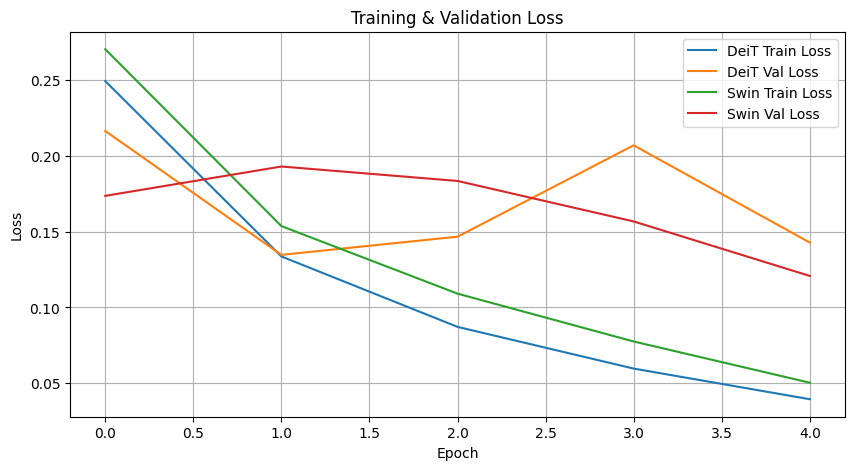

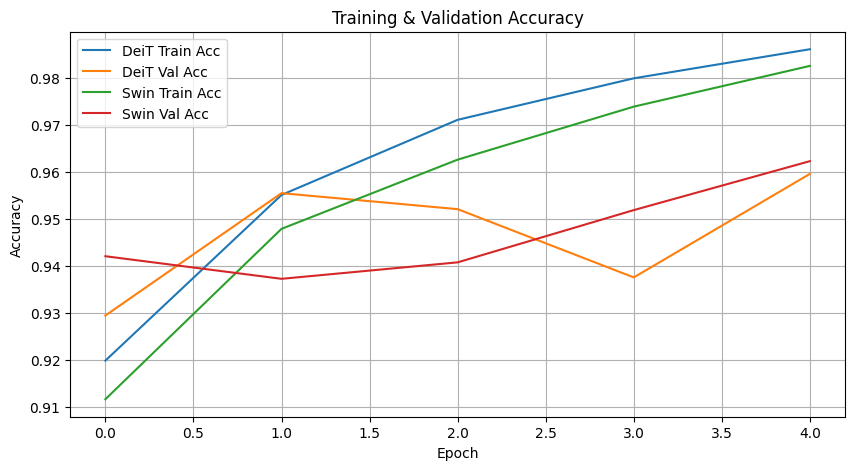

In [8]:
import matplotlib.pyplot as plt

# --- Grafik Loss ---
plt.figure(figsize=(10,5))
plt.plot(history['deit_train_loss'], label='DeiT Train Loss')
plt.plot(history['deit_val_loss'], label='DeiT Val Loss')
plt.plot(history['swin_train_loss'], label='Swin Train Loss')
plt.plot(history['swin_val_loss'], label='Swin Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Grafik Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(history['deit_train_acc'], label='DeiT Train Acc')
plt.plot(history['deit_val_acc'], label='DeiT Val Acc')
plt.plot(history['swin_train_acc'], label='Swin Train Acc')
plt.plot(history['swin_val_acc'], label='Swin Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x800 with 0 Axes>

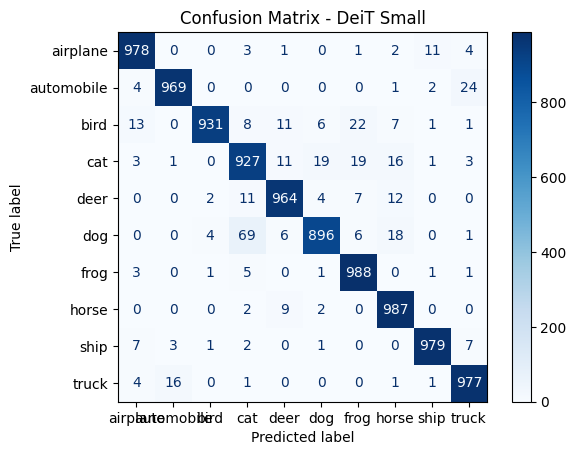

=== RINGKASAN MODEL DEIT SMALL ===
Total Data  : 10000
Total Benar : 9596
Total Salah : 404
Akurasi     : 95.96000000000001 %

Akurasi Per Kelas:
- airplane: 97.80%
- automobile: 96.90%
- bird: 93.10%
- cat: 92.70%
- deer: 96.40%
- dog: 89.60%
- frog: 98.80%
- horse: 98.70%
- ship: 97.90%
- truck: 97.70%

=== Classification Report DEIT ===
              precision    recall  f1-score   support

    airplane       0.97      0.98      0.97      1000
  automobile       0.98      0.97      0.97      1000
        bird       0.99      0.93      0.96      1000
         cat       0.90      0.93      0.91      1000
        deer       0.96      0.96      0.96      1000
         dog       0.96      0.90      0.93      1000
        frog       0.95      0.99      0.97      1000
       horse       0.95      0.99      0.97      1000
        ship       0.98      0.98      0.98      1000
       truck       0.96      0.98      0.97      1000

    accuracy                           0.96     10000
   macro

<Figure size 800x800 with 0 Axes>

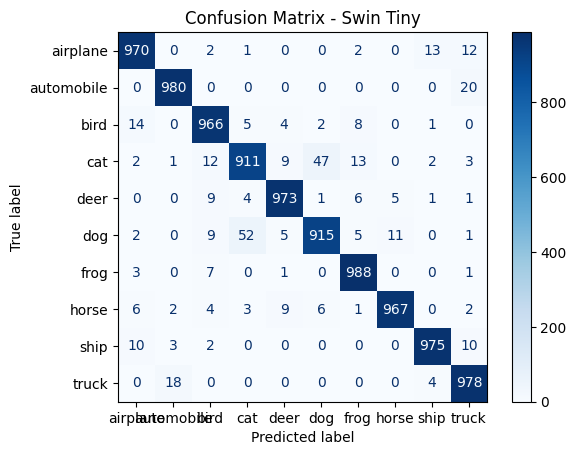

=== RINGKASAN MODEL SWIN TINY ===
Total Data  : 10000
Total Benar : 9623
Total Salah : 377
Akurasi     : 96.23 %

Akurasi Per Kelas:
- airplane: 97.00%
- automobile: 98.00%
- bird: 96.60%
- cat: 91.10%
- deer: 97.30%
- dog: 91.50%
- frog: 98.80%
- horse: 96.70%
- ship: 97.50%
- truck: 97.80%

=== Classification Report SWIN ===
              precision    recall  f1-score   support

    airplane       0.96      0.97      0.97      1000
  automobile       0.98      0.98      0.98      1000
        bird       0.96      0.97      0.96      1000
         cat       0.93      0.91      0.92      1000
        deer       0.97      0.97      0.97      1000
         dog       0.94      0.92      0.93      1000
        frog       0.97      0.99      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.98      0.97      0.98      1000
       truck       0.95      0.98      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ===========================
#       FUNGSI PREDIKSI
# ===========================
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


# =====================================================
#                 CONFUSION MATRIX - DEIT
# =====================================================

labels_true_deit, labels_pred_deit = get_predictions(model_deit, testloader)
cm_deit = confusion_matrix(labels_true_deit, labels_pred_deit)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm_deit, display_labels=trainset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - DeiT Small")
plt.show()

# === RINGKASAN DEIT ===
print("=== RINGKASAN MODEL DEIT SMALL ===")
total_benar = np.sum(np.diag(cm_deit))
total_data = np.sum(cm_deit)
total_salah = total_data - total_benar

print("Total Data  :", total_data)
print("Total Benar :", total_benar)
print("Total Salah :", total_salah)
print("Akurasi     :", total_benar / total_data * 100, "%")

print("\nAkurasi Per Kelas:")
for idx, cls in enumerate(trainset.classes):
    acc = cm_deit[idx][idx] / np.sum(cm_deit[idx]) * 100
    print(f"- {cls}: {acc:.2f}%")

print("\n=== Classification Report DEIT ===")
print(classification_report(labels_true_deit, labels_pred_deit, target_names=trainset.classes))


# =====================================================
#                 CONFUSION MATRIX - SWIN
# =====================================================

labels_true_swin, labels_pred_swin = get_predictions(model_swin, testloader)
cm_swin = confusion_matrix(labels_true_swin, labels_pred_swin)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm_swin, display_labels=trainset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Swin Tiny")
plt.show()

# === RINGKASAN SWIN ===
print("=== RINGKASAN MODEL SWIN TINY ===")
total_benar = np.sum(np.diag(cm_swin))
total_data = np.sum(cm_swin)
total_salah = total_data - total_benar

print("Total Data  :", total_data)
print("Total Benar :", total_benar)
print("Total Salah :", total_salah)
print("Akurasi     :", total_benar / total_data * 100, "%")

print("\nAkurasi Per Kelas:")
for idx, cls in enumerate(trainset.classes):
    acc = cm_swin[idx][idx] / np.sum(cm_swin[idx]) * 100
    print(f"- {cls}: {acc:.2f}%")

print("\n=== Classification Report SWIN ===")
print(classification_report(labels_true_swin, labels_pred_swin, target_names=trainset.classes))


In [11]:
save_path = "/content/drive/My Drive/sem 7/saved_models"
os.makedirs(save_path, exist_ok=True)

# Simpan model DeiT
torch.save(model_deit.state_dict(), f"{save_path}/deit_small_cifar10.pth")
print("Model DeiT berhasil disimpan!")

# Simpan model Swin
torch.save(model_swin.state_dict(), f"{save_path}/swin_tiny_cifar10.pth")
print("Model Swin berhasil disimpan!")


Model DeiT berhasil disimpan!
Model Swin berhasil disimpan!
